In [40]:
import os
import pickle

import numpy as np

from tqdm import tqdm

from PIL import Image

from shared_code import check_pershombox_availability
check_pershombox_availability()
from pershombox import calculate_discrete_NPHT_2d

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# from joblib import parallel_backend
from joblib import Parallel, delayed

import xgboost as xgb

In [2]:
help(calculate_discrete_NPHT_2d)

Help on function calculate_discrete_NPHT_2d in module pershombox.pht:

calculate_discrete_NPHT_2d(binary_cubical_complex: <built-in function array>, number_of_directions) -> list
    Calculates NPHT for 2d cubical complexes with equidistant directions.
    
    :param binary_cubical_complex:
    :param number_of_directions:
    :return:



In [3]:
data_root = os.path.join("..", "assets", "animal")
classes = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]

In [4]:
print(len(classes), "classes")
labels = [c_i for c_i, _ in enumerate(classes)]

20 classes


In [6]:
X, y = [], []
n_directions = 1
debug = False

for c_i, c in enumerate(classes):
    
    c_path = os.path.join(data_root, c)
    
    for f in tqdm(os.listdir(c_path)):
        if os.path.isfile(os.path.join(c_path, f)) and f[-4:] == ".tif":
            im_path = os.path.join(c_path, f)
            im = Image.open(im_path)
            imarray = np.array(im.convert('L')).astype(np.uint8)
            
            pdgm = calculate_discrete_NPHT_2d(imarray, n_directions)
            X.append(pdgm)
            y.append(c_i)
            if debug:
                break


backend threads

n_jobs=6 => 35 sec.
n_jobs=1 => 46 sec.

backend processes

n_jobs=8 => 12 sec.
n_jobs=12 => 10 sec.

In [51]:
%timeit

def get_pdgm(data_rooth, c, c_i, n_dir, debug=True):
    X, y = [], []
    
    c_path = os.path.join(data_root, c)
    n_files = sum([1 for f in os.listdir(c_path) if f[-4:] == ".tif"])
    
    for i, f in enumerate(os.listdir(c_path)):
        
        if os.path.isfile(os.path.join(c_path, f)) and f[-4:] == ".tif":
            
            im_path = os.path.join(c_path, f)
            im = Image.open(im_path)
            imarray = np.array(im.convert('L')).astype(np.uint8)
            
            pdgm = calculate_discrete_NPHT_2d(imarray, n_dir)
            X.append(pdgm)
            y.append(c_i)
            if i % 10 == 0:
                print(f"{c_i} => Classe '{c}' computed {(i+1)/n_files}")
            if debug:
                break
    return X, y

n_dir = 16
debug = False

with Parallel(n_jobs=10, prefer="processes") as parallel:

    res = parallel(delayed(get_pdgm)(data_root, c, c_i, n_dir, debug) for c_i, c in enumerate(classes))

X, y = [], []
for X_, y_ in res:
    X.extend(X_)
    y.extend(y_)

print(len(X))
print(len(y))

if not(debug):
    with open(f'X_{n_dir}_dir.pkl', 'wb') as f:
        pickle.dump(X, f)
    
    with open(f'y_{n_dir}_dir.pkl', 'wb') as f:
        pickle.dump(y, f)

1997
1997


In [48]:
n_dir = 2

with open(f'X_{n_dir}_dir.pkl', "rb") as f:
    X = pickle.load(f)

with open(f'y_{n_dir}_dir.pkl', "rb") as f:
    y = pickle.load(f)

In [104]:
N = 20
V = [] # vectorized persistence diagram

for x in X:
    v_list = []
    for i in range(0,len(x),1):
        h0 = x[i][0] # homology of dim 0 in direction "i"
        if len(x[i]) > 1:
            print(len(x[i]))
        tmp = [d-b for b,d in h0]
        tmp.sort(reverse=True)
        if len(tmp) >= N:
            v = tmp[:N]
        else:
            v = tmp + [0]*(N-len(tmp))
        v_list.append(v)
    V.append(np.array(v_list).flatten())
    
V = np.array(V)
print(np.shape(V))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [67]:

kf = KFold(n_splits=10, shuffle=True)

V = np.array(V)
y = np.array(y)

train_scores = []
test_scores = []

for train_index, test_index in kf.split(V):
    X_train, X_test = V[train_index], V[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cls = RandomForestClassifier(n_jobs=8, max_depth=9, n_estimators=100)
#     cls = SVC()

    cls.fit(X_train, y_train)
    
    train_score = cls.score(X_train, y_train)
    test_score = cls.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

print(f"[{n_dir},{N}]")
print(f"TRAIN: {train_scores.mean():.3f} || {train_scores.std():.3f}")
print(f"TEST : {test_scores.mean():.3f} || {test_scores.std():.3f}")

[16,10]
TRAIN: 0.993 || 0.002
TEST : 0.538 || 0.057


In [99]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



X_train, X_test, y_train, y_test = train_test_split(V, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(np.shape(X_train))

n_units = 32

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=np.shape(X_train)[1:]),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_units, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

hist = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=16,
    validation_data=(X_test, y_test),
    shuffle=True
)

(1337, 320)
Epoch 1/100
84/84 [==============================] - 0s 2ms/step - loss: 3.0335 - accuracy: 0.0651 - val_loss: 2.9397 - val_accuracy: 0.0970
Epoch 2/100
84/84 [==============================] - 0s 1ms/step - loss: 2.9055 - accuracy: 0.1062 - val_loss: 2.8676 - val_accuracy: 0.1576
Epoch 3/100
84/84 [==============================] - 0s 1ms/step - loss: 2.7967 - accuracy: 0.1421 - val_loss: 2.7433 - val_accuracy: 0.2136
Epoch 4/100
84/84 [==============================] - 0s 1ms/step - loss: 2.7310 - accuracy: 0.1518 - val_loss: 2.6582 - val_accuracy: 0.1833
Epoch 5/100
84/84 [==============================] - 0s 1ms/step - loss: 2.6462 - accuracy: 0.1735 - val_loss: 2.5960 - val_accuracy: 0.2136
Epoch 6/100
84/84 [==============================] - 0s 1ms/step - loss: 2.5518 - accuracy: 0.1840 - val_loss: 2.5121 - val_accuracy: 0.2318
Epoch 7/100
84/84 [==============================] - 0s 1ms/step - loss: 2.4888 - accuracy: 0.1930 - val_loss: 2.4506 - val_accuracy: 0.2530
E

Epoch 59/100
84/84 [==============================] - 0s 1ms/step - loss: 1.7674 - accuracy: 0.4166 - val_loss: 2.4735 - val_accuracy: 0.3970
Epoch 60/100
84/84 [==============================] - 0s 1ms/step - loss: 1.7991 - accuracy: 0.4293 - val_loss: 2.3994 - val_accuracy: 0.3894
Epoch 61/100
84/84 [==============================] - 0s 1ms/step - loss: 1.7532 - accuracy: 0.4188 - val_loss: 2.4568 - val_accuracy: 0.4106
Epoch 62/100
84/84 [==============================] - 0s 1ms/step - loss: 1.7407 - accuracy: 0.4286 - val_loss: 2.3962 - val_accuracy: 0.4121
Epoch 63/100
84/84 [==============================] - 0s 1ms/step - loss: 1.6992 - accuracy: 0.4308 - val_loss: 2.3643 - val_accuracy: 0.4061
Epoch 64/100
84/84 [==============================] - 0s 1ms/step - loss: 1.6911 - accuracy: 0.4346 - val_loss: 2.3605 - val_accuracy: 0.4106
Epoch 65/100
84/84 [==============================] - 0s 1ms/step - loss: 1.7358 - accuracy: 0.4346 - val_loss: 2.3504 - val_accuracy: 0.4136
Epoch 

In [100]:
max(hist.history["val_accuracy"])

0.4333333373069763

<IPython.core.display.Javascript object>


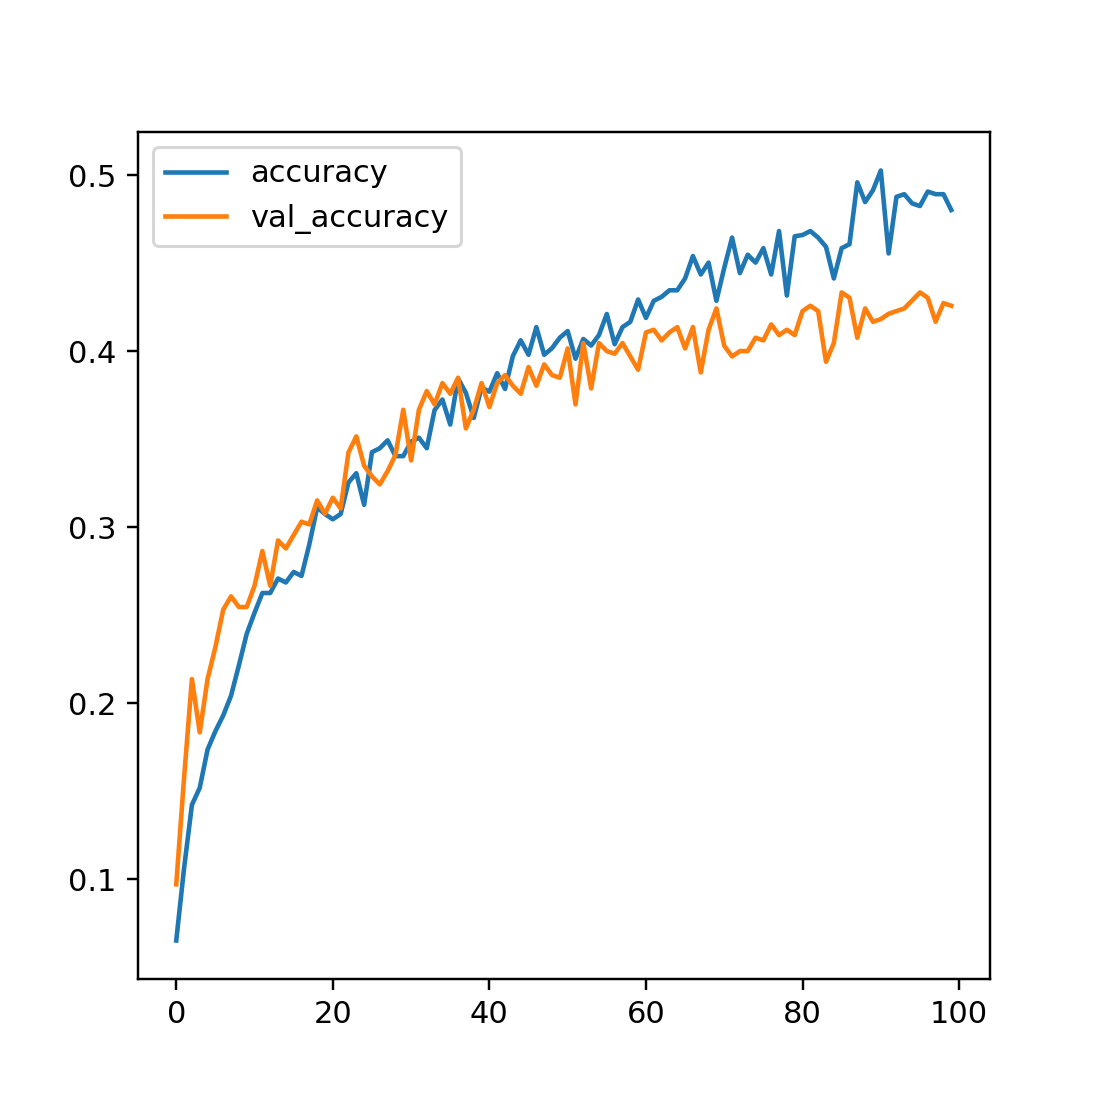

In [103]:
import matplotlib.pyplot as plt

%matplotlib notebook

plt.figure(figsize=(5,5))
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()

#### RandomForest
* [1,10]
TRAIN: 0.789 || 0.007
TEST : 0.282 || 0.019
* [2,10]
TRAIN: 0.793 || 0.007
TEST : 0.279 || 0.050
* [16,10]
TRAIN: 0.988 || 0.001
TEST : 0.501 || 0.022
#### SVC
* [1,10] - 0.158 || 0.026
* [16,10]
TRAIN: 0.365 || 0.009
TEST : 0.304 || 0.024